In [1]:

import torch
import torch.nn as nn
import numpy as np
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os




This Code here implements Squeeze-and-Excitation Networks

This network is capable of capture channle dependacies along with global information.
Therefore, they are better able to recalibrate the filter outputs and thus, this leads to performance gains.

This Squeeze-and-Excitation net consist of two operations,
1. Squeeze: A squeeze operation to get a single value for each channel of output.
2. Excitation: An excitation operation on the output of the squeeze operation to get per-channel weights



In [2]:
class SE_Block(nn.Module):
    "credits: https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py#L4"
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)

This implementation for resnet architecture for CIFAR datasets

In [3]:


__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, r = 16, SE = False, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.SE = SE
        if SE :
            self.se = SE_Block(planes, r)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.SE:
            out = self.se(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, SE = False, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1, SE=SE)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2, SE=SE)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2, SE=SE)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride, SE):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,SE=SE))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [4]:
def resnet20():
    return ResNet(BasicBlock, [3, 3, 3], True) # creating resnet model with attention


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])


def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])


In [5]:
'''
def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith('resnet'):
            print(net_name)
            test(globals()[net_name]())
            print()
            
'''

'\ndef test(net):\n    import numpy as np\n    total_params = 0\n\n    for x in filter(lambda p: p.requires_grad, net.parameters()):\n        total_params += np.prod(x.data.numpy().shape)\n    print("Total number of params", total_params)\n    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))\n\n\nif __name__ == "__main__":\n    for net_name in __all__:\n        if net_name.startswith(\'resnet\'):\n            print(net_name)\n            test(globals()[net_name]())\n            print()\n            \n'

In [6]:
# initializing model without attention 
model_WA = resnet20()
model_WA = torch.nn.DataParallel(model_WA)
model_WA.cuda()
#cudnn.benchmark = True

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model_WA.parameters(), 0.01,
                                momentum=0.99,
                                weight_decay=1e-5)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[100, 150], last_epoch = - 1)

In [7]:
# load CIFAR-10 Dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=128, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)

Files already downloaded and verified


In [8]:

def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        input_var = input.cuda()
        target_var = target
    
        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
            
            
def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 50 == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))

    return top1.avg,input, target

In [9]:


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)

In [10]:
# helper functions
classes = ('0', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')


def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(model, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(model, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(model, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=False)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

current lr 1.00000e-02
Epoch: [0][0/391]	Time 6.813 (6.813)	Data 0.209 (0.209)	Loss 2.5397 (2.5397)	Prec@1 5.469 (5.469)
Epoch: [0][50/391]	Time 0.059 (0.196)	Data 0.000 (0.004)	Loss 1.9822 (2.1423)	Prec@1 26.562 (20.404)
Epoch: [0][100/391]	Time 0.063 (0.130)	Data 0.000 (0.002)	Loss 1.8751 (2.0018)	Prec@1 32.812 (24.590)
Epoch: [0][150/391]	Time 0.063 (0.109)	Data 0.000 (0.002)	Loss 1.7726 (1.9185)	Prec@1 33.594 (28.234)
Epoch: [0][200/391]	Time 0.061 (0.097)	Data 0.000 (0.001)	Loss 1.6342 (1.8614)	Prec@1 35.156 (30.084)
Epoch: [0][250/391]	Time 0.060 (0.091)	Data 0.000 (0.001)	Loss 1.5911 (1.8139)	Prec@1 42.969 (31.941)
Epoch: [0][300/391]	Time 0.130 (0.087)	Data 0.000 (0.001)	Loss 1.4612 (1.7709)	Prec@1 49.219 (33.651)
Epoch: [0][350/391]	Time 0.057 (0.084)	Data 0.000 (0.001)	Loss 1.5440 (1.7341)	Prec@1 44.531 (35.116)
Test: [0/79]	Time 0.263 (0.263)	Loss 1.6350 (1.6350)	Prec@1 42.188 (42.188)
Test: [50/79]	Time 0.029 (0.042)	Loss 1.5929 (1.5411)	Prec@1 39.844 (45.144)
 * Prec@1 45.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 * Prec@1 90.740


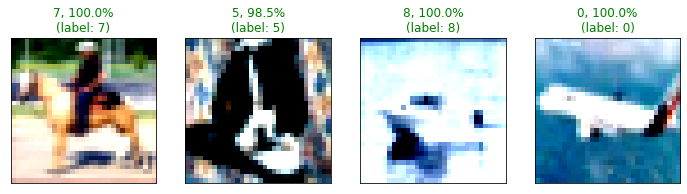

In [11]:
# begin traning and save model 
best_prec1 = 0

for epoch in range(0,200):

        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        train(train_loader, model_WA, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1,val_inputs,val_labels = validate(val_loader, model_WA, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        if epoch > 0 and epoch % 20 == 0:
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model_WA.state_dict(),
                'best_prec1': best_prec1,
            }, is_best, filename=os.path.join('model/', 'checkpoint_WA.th'))

        save_checkpoint({
            'state_dict': model_WA.state_dict(),
            'best_prec1': best_prec1,
        }, is_best, filename = os.path.join('model/', 'model_WA.th'))
fig = plot_classes_preds(model_WA, val_inputs, val_labels)
fig.show()